# Run libraries

In [1]:
library(dplyr, quietly = TRUE, warn.conflicts = FALSE)
library(readr, quietly = TRUE, warn.conflicts = FALSE)
library(CIARA, quietly = TRUE, warn.conflicts = FALSE)
library(Seurat, quietly = TRUE, warn.conflicts = FALSE)
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE)
library(destiny, quietly = TRUE, warn.conflicts = FALSE)
library(parallel, quietly = TRUE, warn.conflicts = FALSE)
library(tidyverse, quietly = TRUE, warn.conflicts = FALSE)
library(ggbeeswarm, quietly = TRUE, warn.conflicts = FALSE)
library(ggthemes, quietly = TRUE, warn.conflicts = FALSE)
library(SingleCellExperiment, quietly = TRUE, warn.conflicts = FALSE)
library(clustree, quietly = TRUE, warn.conflicts = FALSE)

‘SeuratObject’ was built under R 4.3.0 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.1.1 but the current
version is 1.6.2; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

  

In [ ]:
sessionInfo()

# Run prerequest Functions for CIARA

In [2]:
get_background_full_here = function (norm_matrix, threshold = 1, n_cells_low = 3, n_cells_high = 20,
    extend_binarization = FALSE, quant_threshold = 0.9, quant_low = 0.1,
    quant_high = 0.9)
{
    if (!(is.logical(extend_binarization))) {
        stop("extend_binarization must be a logical value. Try with extend_binarization = TRUE or extend_binarization = FALSE")
    }
    if (extend_binarization == FALSE) {
        genes_filter <- apply(norm_matrix, 1, function(x) {
            x <- x[x > threshold]
            if (length(x) >= n_cells_low) {
                return(TRUE)
            }
            else {
                return(FALSE)
            }
        })
        genes_filter_2 <- apply(norm_matrix, 1, function(x) {
            x <- x[x > threshold]
            if (length(x) > n_cells_high) {
                return(FALSE)
            }
            else {
                return(TRUE)
            }
        })
        genes_important <- row.names(norm_matrix)[genes_filter]
        genes_important_2 <- row.names(norm_matrix)[genes_filter_2]
        genes_important_final <- intersect(genes_important, genes_important_2)
        if (length(genes_important_final) == 0) {
            stop("There are not genes that pass the filtering steps")
        }
        return(genes_important_final)
    }
    if (extend_binarization == TRUE) {
        diff_quant <- apply(norm_matrix, 1, function(x) {
            quant_low_th <- quantile(x, quant_low)
            quant_high_th <- quantile(x, quant_high)
            diff_quant <- as.numeric(quant_high_th - quant_low_th)
            return(diff_quant)
        })
        quant_threshold_value <- quantile(diff_quant, quant_threshold)
        if (quant_threshold_value > 0) {
            genes_important_final <- row.names(norm_matrix)[diff_quant >=
                quant_threshold_value]
        }
        if (quant_threshold_value == 0) {
            warning("All the genes are tested. Try with an higher quant_threshold to test a smaller set of genes ")
            genes_important_final <- row.names(norm_matrix)[diff_quant >=
                quant_threshold_value]
        }
        if (length(genes_important_final) == 0) {
            stop("There are not genes that pass the filtering steps")
        }
        return(genes_important_final)
    }
}

###########################################
CIARA_final = function (norm_matrix, knn_matrix, background, cores_number = 1, 
    fdr_value = 0.05, n_cells, approximation = FALSE) 
{
  Matrix::diag(knn_matrix) <- 0
    
  denominator = (as.numeric(length(colnames(norm_matrix)))*as.numeric(length(colnames(norm_matrix))))
  number_binomial = n_cells*n_cells
  probability_combined = (sum(knn_matrix>0))/denominator
  
    run_loop_genes = function(i) {
        if (!all(background %in% row.names(norm_matrix))) {
            stop("Some background genes are not present in norm matrix")
        }
        gene_expression <- as.vector(norm_matrix[background[i], 
            ])
        #message(paste0("Running CIARA on gene:", background[i]))
        return(CIARA_gene_final(norm_matrix, knn_matrix, gene_expression,n_cells, denominator,number_binomial, probability_combined, approximation))
    }
    result_final <- (do.call(rbind, mclapply(seq_len(length(background)), 
        run_loop_genes, mc.cores = cores_number)))
    row.names(result_final) <- background
    if (approximation == FALSE){
    colnames(result_final) <- c("rank_genes","p_value","rank_genes_final")
    fdr_values <- as.vector(p.adjust(as.vector(result_final[,2]), method ="fdr"))
    result_final <- cbind(result_final,fdr_values)
    result_final <- result_final[result_final[,4]<= fdr_value, ]  
    return(result_final)
    }
    if (approximation == TRUE){
      colnames(result_final) <- c("rank_genes","rank_genes_final")
      result_final <- result_final[result_final[,2]>=1,]
    
    
    return(result_final)
    }
}

###########################################
CIARA_gene_final = function (norm_matrix, knn_matrix, gene_expression, n_cells, denominator,number_binomial, probability_combined, approximation = FALSE)
{




  
  if (approximation == FALSE){
    names(gene_expression) = colnames(norm_matrix)
    gene_expression_sort = sort(gene_expression, decreasing = T)
    gene_expression_sort= gene_expression_sort[gene_expression_sort!=0]
    if (length(gene_expression_sort) >= n_cells ){
    gene_expression_sort_top = gene_expression_sort[1:n_cells]
    }
    else{
      gene_expression_sort_top = gene_expression_sort
    }
    sub_feature = names(gene_expression_sort_top)
    knn_matrix_small <- knn_matrix[sub_feature,sub_feature]
    rank_gene = sum(as.vector(knn_matrix_small)>0)
    
    #rank_gene_final = rank_gene 
   # number_binomial = n_cells*n_cells
 # probability_combined = (sum(knn_matrix>0))/denominator
    
      #rank_gene_final = rank_gene 
   # number_binomial = n_cells*n_cells
  #probability_combined = (sum(knn_matrix>0))/denominator
    
    pvalue_binomial <- binom.test(rank_gene,number_binomial, 
        probability_combined, alternative = c("greater"))$p.value


    return(list(rank_gene, pvalue_binomial,rank_gene))
}
  

  if (approximation == TRUE) {
    names(gene_expression) = colnames(norm_matrix)
  gene_expression_sort = sort(gene_expression, decreasing = T)
  gene_expression_sort= gene_expression_sort[gene_expression_sort!=0]
  if (length(gene_expression_sort) >= n_cells ){
    gene_expression_sort_top = gene_expression_sort[1:n_cells]
  }
  else{
    gene_expression_sort_top = gene_expression_sort
  }
  sub_feature = names(gene_expression_sort_top)
  knn_matrix_small <- knn_matrix[sub_feature,sub_feature]
  rank_gene = sum(as.vector(knn_matrix_small)>0)
  if ( rank_gene >= n_cells){
    rank_gene_final = rank_gene
  
  }
  else{
    n_cells_here = length(gene_expression_sort)
    rank_gene_final = rank_gene 
    
  }
  


  return(list(rank_gene,rank_gene_final))
    
  }
}

###########################################
detect_localized_genes_final=function (knn_matrix, norm_matrix, genes_sort, top_number, threshold = 1,cores_number =1, approximation = FALSE, extend_binarization = FALSE, n_cells = 10) {
  
  
  Matrix::diag(knn_matrix) <- 0
  if (!is.logical(approximation)){
    stop(paste0("approximation must be logical"))
  }
  
  if (!is.logical(extend_binarization)){
    stop(paste0("extend_binarization must be logical"))
  }
  
  if (extend_binarization == TRUE){
  norm_matrix_extend = apply(norm_matrix[genes_sort,],1,function(x){
    names(x) = colnames(norm_matrix)
    x_sort = sort(x, decreasing = T)
    x_sort= x_sort[x_sort!=0]
    if (length(x_sort) >= n_cells ){
   x_sort_top = x_sort[1:n_cells]
    }
    else{
      x_sort_top = x_sort
    }
    y = rep(0,length(x))
    y[colnames(norm_matrix)%in%names(x_sort_top)] =1 
    return(y)
  }
  
  )
  
  norm_matrix_extend = t(norm_matrix_extend)
  colnames(norm_matrix_extend) = colnames(norm_matrix)
  norm_matrix = norm_matrix_extend
  threshold = 0
  }
  
  if (approximation == FALSE){
    run_localized_genes = function(i){       
  #print(i)
       knn_name = (which(knn_matrix[i, ] > 0))
        genes_select <- genes_sort[1:top_number]
        sum_knn <- apply(norm_matrix[genes_select, knn_name], 
            2, function(x) {
                somma <- genes_select[which(x > threshold)]
                return(somma)
            })
        list_intersect<- unique(as.vector(unlist(sum_knn))[duplicated(as.vector(unlist(sum_knn)))])
        rank_intersect <- length(list_intersect)
        #print(rank_intersect)
        return(list(list_intersect,rank_intersect))
    }
    result_final <- do.call(rbind, mclapply(seq_len(length(colnames(knn_matrix))), 
        run_localized_genes, mc.cores = cores_number))
    
    
result_final=as.data.frame(result_final)

list_intersect = result_final[,1]
rank_intersect = unlist(result_final[,2])

    return(list(rank_intersect,list_intersect))
  }
  
  if (approximation == TRUE){
 
  genes_select <- genes_sort[1:top_number]
  cells_kept = apply(norm_matrix[genes_select,],2,function(x){
    somma <- sum(x>threshold)
    if (somma >=1){
      return(TRUE)
    }
    else{
      return(FALSE)
    }
  })
  
  cells_kept_final=colnames(norm_matrix)[cells_kept]
  
  #print(length(cells_kept_final))
  
  norm_matrix_small = norm_matrix
  knn_matrix_small = knn_matrix[cells_kept_final,]
  
  
  run_localized_genes = function(i){       
  #print(i)
       #knn_name = names(which(knn_matrix[i, ] > 0))
       knn_name = (which(knn_matrix_small[i, ] > 0))
        genes_select <- genes_sort[1:top_number]
        sum_knn <- apply(norm_matrix_small[genes_select, knn_name], 
            2, function(x) {
                somma <- genes_select[which(x > threshold)]
                return(somma)
            })
        list_intersect<- unique(as.vector(unlist(sum_knn))[duplicated(as.vector(unlist(sum_knn)))])
        rank_intersect <- length(list_intersect)
        #print(rank_intersect)
        return(list(list_intersect,rank_intersect))
    }
    result_final <- do.call(rbind, mclapply(seq_len(length(row.names(knn_matrix_small))), 
        run_localized_genes, mc.cores = cores_number))
    
   
  
  result_final=as.data.frame(result_final)

list_intersect = result_final[,1]
rank_intersect = unlist(result_final[,2])

 rank_intersect_final = rep(0,length(cells_kept))
  rank_intersect_final[cells_kept] = rank_intersect
  
  list_intersect_final = rep(list(character(0)),length(cells_kept))
  list_intersect_final[cells_kept] = list_intersect
  
    return(list(rank_intersect_final,list_intersect_final))
  } 
}

###########################################

find_cluster_final = function(rank_intersect,list_intersect, norm_matrix, min_loc_genes = 1){
  
  
  #rank_intersect = rank_intersect
  #list_intersect = list_intersect
  #norm_mtrix = norm_matrix
  #knn_matrix = knn_matrix
  #min_loc_genes = 5
  #threshold_jaccard = 0.5
  
if(min_loc_genes >= max(rank_intersect)){
  stop(paste0("min_loc_genes must be lower than ", max(rank_intersect)))
}
list_intersect_small = list_intersect[rank_intersect>min_loc_genes]



matrix_common = matrix(0,ncol = length(list_intersect_small),nrow = length(list_intersect_small))

## Find common localized genes between cells i and j
for (i in 1:length(list_intersect_small)){
  for (j in 1:length(list_intersect_small)){
    if (length((as.vector(list_intersect_small[i])[[1]])) >0 & length((as.vector(list_intersect_small[j])[[1]]))>0){ 
  matrix_common[i,j]=length(intersect(as.vector(list_intersect_small[i])[[1]],as.vector(list_intersect_small[j])[[1]]))
      
    }
    else{
      matrix_common[i,j] = 0
    }
  }
}

## If the intersection is below a given threshold, then the entry is set to 0
matrix_common_new=matrix_common

for (i in 1:length(list_intersect_small)){
  for (j in 1:length(list_intersect_small)){
    if (matrix_common[i,j]<=min_loc_genes ){  
  matrix_common_new[i,j]=0
    }
    else{
      matrix_common_new[i,j] = matrix_common[i,j]
    }
  }
}



matrix_common=as.data.frame(matrix_common)

colnames(matrix_common_new)=colnames(norm_matrix)[rank_intersect>min_loc_genes]

row.names(matrix_common_new)=colnames(norm_matrix)[rank_intersect>min_loc_genes]

common_cells_update = rep(list(0),length(row.names(matrix_common)))



jaccard_matrix_new=matrix_common_new

k=1
l =1
iter=1
common_cells = rep(list(0),length(row.names(matrix_common)))
while(k>0){
 
  

index_common = which(jaccard_matrix_new[k,]> min_loc_genes )


if (length(index_common)<=2){
  
  iter=iter+1
  k=k+1
  index_plus = colnames(jaccard_matrix_new)[index_common]

jaccard_matrix_new = jaccard_matrix_new[!row.names(jaccard_matrix_new)%in%index_plus, !row.names(jaccard_matrix_new)%in%index_plus]
}
if (length(index_common)>2){

test_jaccard = jaccard_matrix_new[index_common,]
max_test_jaccard= apply(test_jaccard,1,function(x){
  index = (which(x == max(x)))
  relevant_index = which(x>0)
  cells_here = colnames(test_jaccard)[colnames(test_jaccard)%in%row.names(test_jaccard)]
    cells_not_here = colnames(test_jaccard)[!colnames(test_jaccard)%in%row.names(test_jaccard)]
    
    relevant_cells = colnames(test_jaccard)[relevant_index]
    
    sum_here = sum(relevant_cells %in% cells_here)
    sum_not_here = sum(relevant_cells %in% cells_not_here)
    
  
    if ((sum(colnames(test_jaccard)[index]%in%row.names(test_jaccard)) > 0) & (sum_here > sum_not_here) & (sum_here>=3)  )
    return(TRUE)
  else{
    #print("IS FALSE")
    return(FALSE)
    }
})

index_common_update= index_common[max_test_jaccard]
index_plus = colnames(jaccard_matrix_new)[index_common_update]
common_cells[[l]]=index_plus
  
jaccard_matrix_new = jaccard_matrix_new[!row.names(jaccard_matrix_new)%in%common_cells[[l]],!row.names(jaccard_matrix_new)%in%common_cells[[l]]]

k = 1
l =l +1
iter=iter+1
}
if (length(row.names(jaccard_matrix_new)) <= 2){
  k=0
  break
}

if (iter > length(row.names(matrix_common_new))){
  break
}
if (k>length(row.names(jaccard_matrix_new))){
  break
}
}

common_cells_small = common_cells[lengths(common_cells)>2]
return(common_cells_small)

}

###########################################
explore_genes_final = function(rank_intersect,list_intersect, norm_matrix,min_gene, max_gene, step_gene){
  
try_min_loc_genes = seq(min_gene,max_gene,step_gene)
cells_min_loc_genes = rep(list(0),length(try_min_loc_genes))


for (i in 1:length(try_min_loc_genes)){
  cells_min_loc_genes[[i]] = find_cluster_final(rank_intersect,list_intersect,norm_matrix, min_loc_genes = try_min_loc_genes[i])
}


all_cells= unlist(cells_min_loc_genes)
all_cells = unique(all_cells)

cluster_start_list = rep(list(0),length(try_min_loc_genes))
for (i in 1:length(try_min_loc_genes)){
cluster_start=rep("Other cluster",length(all_cells))
if(length(cells_min_loc_genes[[i]])>0){
cells_min_loc_genes_single = cells_min_loc_genes[[i]]
for (j in 1:length(cells_min_loc_genes_single)){
cluster_start[all_cells%in%cells_min_loc_genes_single[[j]] ] = j
}
cluster_start_list[[i]] = cluster_start
}
else{
 cluster_start_list[[i]] = rep("Other cluster",length(all_cells))
}
}

cluster_matrix=matrix(unlist(cluster_start_list), byrow=FALSE, ncol = length(cluster_start_list) )

iterat = seq(min_gene,max_gene,step_gene)
iterat_name=paste0("G",iterat)
colnames(cluster_matrix)=iterat_name
row.names(cluster_matrix) = all_cells
p = clustree(cluster_matrix, prefix = "G")

p
return(list(p,cluster_matrix))
}

###########################################

find_number_clusters_final = function(norm_matrix,rank_intersect,list_intersect, threshold = 0.50, min_genes_common = 8, max_rank_intersect = 20 ){
  
  #norm_matrix = norm_matrix_neuron_small
  #rank_intersect = rank_here
  #threshold = 0.50
  #min_genes_common = 3
  #max_rank_intersect = 20
  #min_gene = 1
  #list_intersect = list_intersect_here
if (max(rank_intersect) <= max_rank_intersect ){
  if (max(rank_intersect) >= 10){
  #min_genes_common = round(0.4* max(rank_intersect_atac),1)
  }
  else{
    #min_genes_common = 3
  }
  #max_rank_intersect = max(rank_intersect)
  
  
}
  
  max_gene = max_rank_intersect
  step_gene = 1
  #min_gene = min_genes_common - 1
  min_gene = 1
  
  out_explore_genes = explore_genes_final(rank_intersect,list_intersect,norm_matrix,min_gene, max_gene, step_gene)
  cluster_matrix = out_explore_genes[[2]]
cluster_g1 = names(table(cluster_matrix[,1]))
cluster_g1 = cluster_g1[cluster_g1!="Other cluster"]
score_g1 = rep(list(0),length(cluster_g1))
for ( i in 1:length(cluster_g1)){
  cluster_name = cluster_g1[i]
  cluster_all_name = cluster_matrix[,1]
  cells_name = row.names(cluster_matrix)[cluster_all_name == cluster_name]
   count = 0
   for (j in 1:length(colnames(cluster_matrix))){
  
     cluster_j = cluster_matrix[cells_name,j]
     cluster_j = cluster_j[cluster_j!="Other cluster"]
     count_next = as.vector(table(cluster_j))
    
     if (sum(count_next > threshold*length(cells_name))>=1){
       count = count+1
     }
   }
  score_g1[[i]] = count
  names(score_g1[[i]])=cluster_g1[i]
}

clusters = names(unlist(score_g1))
score = as.vector(unlist(score_g1))
data = data.frame(clusters, score)
p<-ggplot(data, aes(x=clusters, y=score)) +
  geom_bar(stat="identity") + ylim(c(0,max(score))) + scale_y_continuous(breaks= seq(0,max(score),1), limits=c(0, max(score)))

if (sum(score>=min_genes_common)>=1){
  final_clu = find_cluster_final(rank_intersect,list_intersect,norm_matrix, min_loc_genes = min_gene)
  
  cluster_final=rep("Other cluster",length(colnames(norm_matrix)))


for (i in 1:length(final_clu)){
cluster_final[colnames(norm_matrix)%in%final_clu[[i]]] = i
}
  
 cluster_final[!cluster_final %in% cluster_g1[score>=min_genes_common] ] =  "Other cluster"
 
 cluster_rare = names(table(cluster_final))[names(table(cluster_final))!="Other cluster"]
marker_final = rep(list(0), length(cluster_rare))

for (i in 1:length(cluster_rare)){

marker_final[[i]] = unique(unlist(list_intersect[cluster_final%in%cluster_rare[i]]))
}

if (length(marker_final) >1){
common_genes = Reduce(intersect,marker_final)


if (length(common_genes)>=1){
  for (i in 1:length(cluster_rare)){

marker_final[[i]] = marker_final[[i]][!marker_final[[i]]%in%common_genes]
}
}
}


## New part
min_gene_final = min_genes_common - 1
#min_gene_final = min_genes_common 
final_clu_max = find_cluster_final(rank_intersect,list_intersect,norm_matrix, min_loc_genes = min_gene_final)


cluster_final_max=rep("Other cluster",length(colnames(norm_matrix)))
kept_cells = colnames(norm_matrix)[cluster_final%in%cluster_rare]
  for (i in 1:length(final_clu_max)){
    final_clu_max[[i]] = intersect(final_clu_max[[i]],kept_cells)
cluster_final_max[colnames(norm_matrix)%in%final_clu_max[[i]]] = i

  }

cluster_rare_max = names(table(cluster_final_max))[names(table(cluster_final_max))!="Other cluster"]
marker_final_max = rep(list(0), length(cluster_rare_max))

for (i in 1:length(cluster_rare_max)){

marker_final_max[[i]] = unique(unlist(list_intersect[cluster_final_max%in%cluster_rare_max[i]]))
#marker_final_max[[i]] = Reduce(intersect,list_intersect[cluster_final_max%in%cluster_rare_max[i]])
}

if (length(marker_final_max) >1){
  
#common_genes_max = Reduce(intersect,marker_final_max)
common_genes_all = unlist(marker_final_max)
common_genes_all = unique(common_genes_all[!isUnique(unlist(marker_final_max))])
#index_merge = rep(list(0),length(marker_final_max))
#for (j in 1:length(marker_final_max)){
#index_common = which(marker_final_max[[j]]%in%common_genes_all)
#if (index_common >= min_gene_final){
  #index_merge[[j]] = j
#}
#}
#index_merge_all = unlist(index_merge)

if (length(common_genes_all)>=1){
  index_remove = rep(0,length(cluster_rare_max))
  for (i in 1:length(cluster_rare_max)){

marker_final_max[[i]] = marker_final_max[[i]][!marker_final_max[[i]]%in%common_genes_all]

if (length(marker_final_max[[i]]) <= min_gene_final){
  index_remove[i] = i
}
  }
  
  if (sum(index_remove)>0){

    #print(marker_final_max)
marker_final_max = marker_final_max[index_remove==0]
#print(marker_final_max)
cluster_final_max[cluster_final_max%in%c(cluster_rare_max[index_remove!=0])] = "Other cluster"
}
  
}



}


cluster_remove = names(table(cluster_final_max))[table(cluster_final_max)<3]
if (length(cluster_remove)>=1){
level_cluster_final = levels(factor(cluster_final_max))
level_cluster_final = level_cluster_final[level_cluster_final!="Other cluster"]
print(marker_final_max)
marker_final_max = marker_final_max[level_cluster_final!=cluster_remove]
#print(marker_final_max)
#print(cluster_remove)
#print(level_cluster_final)
cluster_final_max[cluster_final_max%in%cluster_remove] = "Other cluster"
}

}

else{
  cluster_final_max=rep("Other cluster",length(colnames(norm_matrix)))
  marker_final_max = list(0)
}

return(list(out_explore_genes[[1]],p, score_g1, cluster_final_max, marker_final_max))
}

###########################################

plot_localized_genes_interactive_here = function (coordinate_umap, norm_matrix, rank_intersect, text,
    ramp_list, min_x = NULL, max_x = NULL, min_y = NULL, max_y = NULL)
{
    index_sort <- order(rank_intersect)
    text = text[index_sort]
    row.names(coordinate_umap) <- colnames(norm_matrix)
    coordinate_umap <- coordinate_umap[colnames(norm_matrix)[index_sort],
        ]
    rank_intersect <- sort(rank_intersect)
    if (!requireNamespace("plotly", quietly = TRUE)) {
        stop("Package plotly needed for interactive == TRUE. Please install it: install.packages('plotly')")
    }
    colnames(coordinate_umap) <- c("UMAP_1", "UMAP_2")
    fig <- plotly::plot_ly(data = coordinate_umap, x = ~UMAP_1,
        y = ~UMAP_2, type = "scatter", mode = "markers", marker = list(color = ~rank_intersect,
            size = 5, width = 2, line = list(color = "black",
                width = 0.5), colorbar = list(title = "Number of rare cell markers\nshared with neighbors"),
            showscale = TRUE, colorscale = ramp_list), text = ~text,
        hoverinfo = "text")
    if (!is.null(min_x)) {
        fig <- fig %>% plotly::layout(xaxis = list(range = c(min_x,
            max_x)), yaxis = list(range = c(min_y, max_y))) %>%
            plotly::layout(plot_bgcolor = "rgb(254, 247, 234)") %>%
            plotly::layout(paper_bgcolor = "rgb(254, 247, 234)")
    }
    return(fig)
}

###########################################
names_localized_genes=function (list_intersect, genes_sort, max_number = 5){ 
  text <- rep(0,length(list_intersect))
  
  for (i in 1:length(list_intersect)) {
    if (length(list_intersect[[i]]) == 0){
      localized_genes <- "No specific genes"
      text[i] <- "No specific genes"
      
    }
    else {
      localized_genes <- genes_sort[which(genes_sort %in% list_intersect[[i]])]
      
      max_genes <- min(max_number, length(localized_genes))
      if (max_genes < max_number){
        #warning("max_number bigger than length of localized_genes. Set max_number = length(localized_genes) ")
      }
      localized_genes <- localized_genes[1:max_genes]
      text[i] <- paste(localized_genes, collapse = "-")
      
      
    }
  }
  return(text)
}

###########################################
###########################################
###########################################

# Read data

In [3]:
setwd('~/Desktop/LMU/4 - semester/research course internship/')
vedo=read_rds('xenopus_combined_and_clustered_no_out.rds')
vedo = UpdateSeuratObject(object = vedo)
subset_data <- subset(vedo, idents = 9)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Updating matrix keys for DimReduc ‘pca’

Updating matrix keys for DimReduc ‘umap’

Updating matrix keys for DimReduc ‘tsne’

Warning message:
“Assay RNA changing from Assay to Assay”
Warning message:
“Assay integrated changing from Assay to Assay”
Warning message:
“DimReduc pca changing from DimReduc to DimReduc”
Warning message:
“DimReduc umap changing from DimReduc to DimReduc”
Warning message:
“DimReduc tsne changing from DimReduc to DimReduc”
Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in integrated

Updating slots in pca

Updating slots in umap

Setting umap DimReduc to global

Updating slots in tsne

Setting tsne DimReduc to global

No assay information could be found for FindIntegrationAnchors

Warning message:
“Adding a command log without an assay associated with it”
No assay information coul

# Determine the majority of the variation by where the elbow occurs
https://hbctraining.github.io/scRNA-seq/lessons/elbow_plot_metric.html

In [17]:
# Determine percent of variation associated with each PC
pct <- subset_data[["pca"]]@stdev / sum(subset_data[["pca"]]@stdev) * 100

# Calculate cumulative percents for each PC
cumu <- cumsum(pct)

# Determine which PC exhibits cumulative percent greater than 90% and % variation associated with the PC as less than 5
co1 <- which(cumu > 90 & pct < 5)[1]

co1

[1] 44

In [18]:
# Determine the difference between variation of PC and subsequent PC
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.1), decreasing = T)[1] + 1

# last point where change of % of variation is more than 0.1%.
co2

[1] 7

In [19]:
pct

[1] 9.908454 5.738758 3.513386 3.023764 2.801197 2.451449 2.163908 2.094283
 [9] 2.040888 2.026946 2.002850 1.947061 1.877774 1.861059 1.820696 1.778893
[17] 1.764507 1.739943 1.709178 1.688468 1.678195 1.672044 1.656622 1.638256
[25] 1.626335 1.614254 1.597162 1.583004 1.574191 1.567917 1.566527 1.554052
[33] 1.542499 1.534957 1.524148 1.519320 1.515172 1.505220 1.497083 1.488445
[41] 1.485390 1.474850 1.472568 1.468353 1.462687 1.461109 1.453563 1.447118
[49] 1.435944 1.429553

In [20]:
# Minimum of the two calculation
pcs <- min(co1, co2)

pcs

[1] 7

new("standardGeneric", .Data = function (x, decreasing = FALSE, 
    ...) 
standardGeneric("sort"), generic = "sort", package = "BiocGenerics", 
    group = list(), valueClass = character(0), signature = "x", 
    default = new("derivedDefaultMethod", .Data = function (x, 
        decreasing = FALSE, ...) 
    {
        if (!is.logical(decreasing) || length(decreasing) != 
            1L) 
            stop("'decreasing' must be a length-1 logical vector.\nDid you intend to set 'partial'?")
        UseMethod("sort")
    }, target = new("signature", .Data = "ANY", names = "x", 
        package = "methods"), defined = new("signature", .Data = "ANY", 
        names = "x", package = "methods"), generic = "sort"), 
    skeleton = (new("derivedDefaultMethod", .Data = function (x, 
        decreasing = FALSE, ...) 
    {
        if (!is.logical(decreasing) || length(decreasing) != 
            1L) 
            stop("'decreasing' must be a length-1 logical vector.\nDid you intend to set 'partial'?")
        UseMethod("sort")
    }, target = new("signature", .Data = "ANY", names = "x", 
        package = "methods"), defined = new("signature", .Data = "ANY", 
        names = "x", package = "methods"), generic = "sort"))(x, 
        decreasing, ...))
<bytecode: 0x7ff2b256a238>
<environment: 0x7ff2b2570e78>
attr(,"generic")
[1] "sort"
attr(,"generic")attr(,"package")
[1] "BiocGenerics"
attr(,"package")
[1] "BiocGenerics"
attr(,"group")
list()
attr(,"valueClass")
character(0)
attr(,"signature")
[1] "x"
attr(,"default")
Method Definition (Class "derivedDefaultMethod"):

function (x, decreasing = FALSE, ...) 
{
    if (!is.logical(decreasing) || length(decreasing) != 1L) 
        stop("'decreasing' must be a length-1 logical vector.\nDid you intend to set 'partial'?")
    UseMethod("sort")
}
<bytecode: 0x7ff2b2573818>
<environment: namespace:base>

Signatures:
        x    
target  "ANY"
defined "ANY"
attr(,"skeleton")
(new("derivedDefaultMethod", .Data = function (x, decreasing = FALSE, 
    ...) 
{
    if (!is.logical(decreasing) || length(decreasing) != 1L) 
        stop("'decreasing' must be a length-1 logical vector.\nDid you intend to set 'partial'?")
    UseMethod("sort")
}, target = new("signature", .Data = "ANY", names = "x", package = "methods"), 
    defined = new("signature", .Data = "ANY", names = "x", package = "methods"), 
    generic = "sort"))(x, decreasing, ...)
attr(,"class")
[1] "standardGeneric"
attr(,"class")attr(,"package")
[1] "methods"

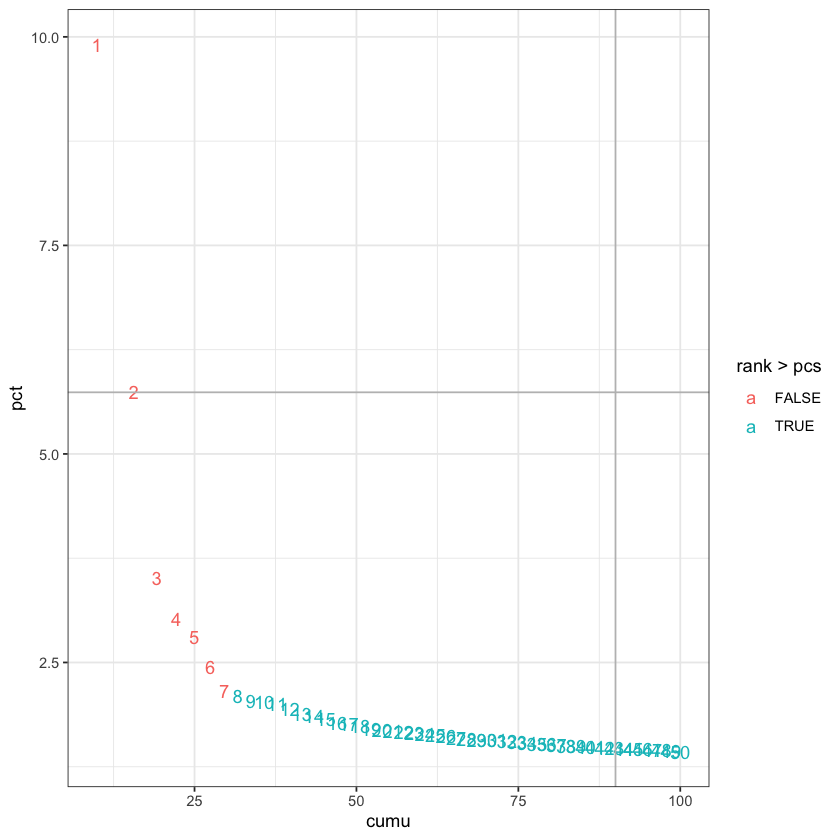

In [21]:
sort# Create a dataframe with values
plot_df <- data.frame(pct = pct, 
           cumu = cumu, 
           rank = 1:length(pct))

# Elbow plot to visualize 
  ggplot(plot_df, aes(cumu, pct, label = rank, color = rank > pcs)) + 
  geom_text() + 
  geom_vline(xintercept = 90, color = "grey") + 
  geom_hline(yintercept = min(pct[pct > 5]), color = "grey") +
  theme_bw()

# Cluster the cells
https://www.biostars.org/p/9572463/#9572470

In [22]:
subset_data <- FindNeighbors(subset_data, dims = 1:pcs)


Computing nearest neighbor graph

Computing SNN



In [23]:
# Jonathan choose resolution=0.5 and nr neighbors (k)=20

In [24]:
subset_data <- FindClusters(
  subset_data,
  dims.use = 1:pcs,
  force.recalc = TRUE,
  print.output = TRUE,
  resolution = 0.5,
  save.SNN = TRUE)

Warning message:
“The following arguments are not used: dims.use, force.recalc, print.output, save.SNN”
Suggested parameter: dims instead of dims.use; verbose instead of print.output


Warning message:
“The following arguments are not used: dims.use, force.recalc, print.output, save.SNN”
Suggested parameter: dims instead of dims.use; verbose instead of print.output




Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 134
Number of edges: 2704

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8004
Number of communities: 3
Elapsed time: 0 seconds


In [25]:
subset_data <- RunUMAP(subset_data, dims = 1:pcs)
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:40:27 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

11:40:27 Read 134 rows and found 7 numeric columns

11:40:27 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

11:40:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:40:27 Writing NN index file to tem

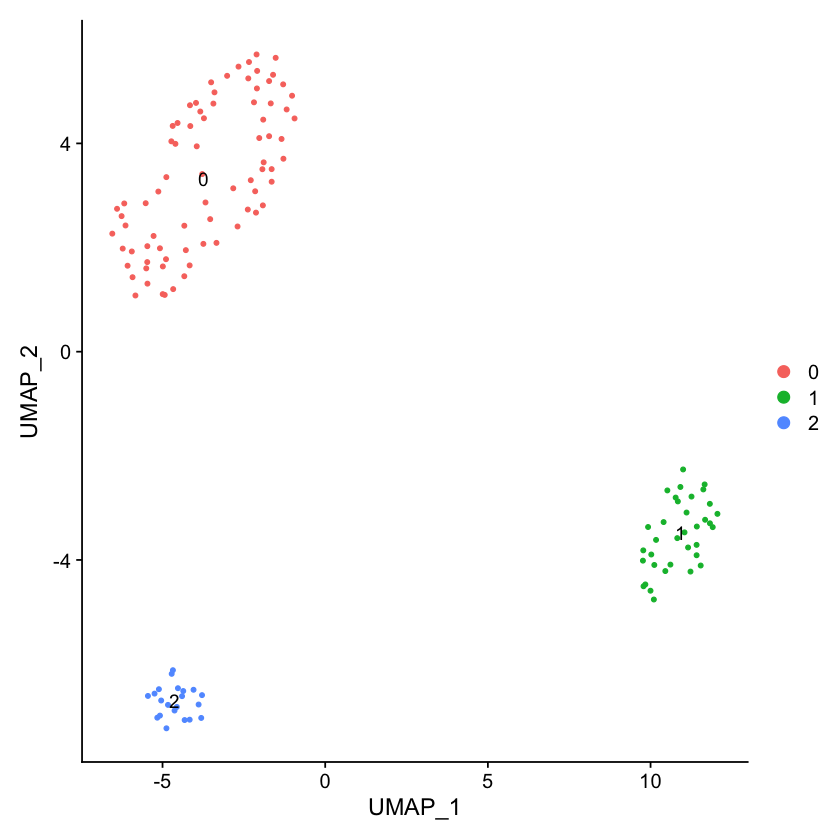

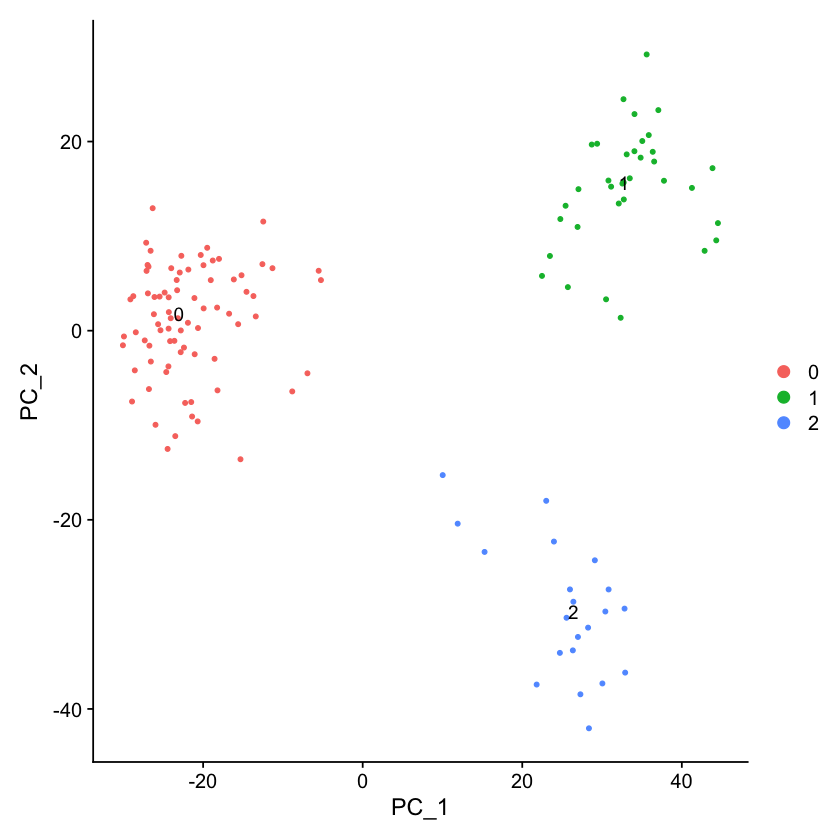

In [26]:
DimPlot(subset_data, reduction = "umap", label = TRUE)
DimPlot(subset_data, reduction = "pca", label = TRUE)

In [27]:
# change the label
for (a in 1:nrow(subset_data@meta.data)) {
  if (subset_data@meta.data$orig.ident[a] == "SIGAA2"){
    subset_data@meta.data$exp[a] = "exp1"
  }
  if (subset_data@meta.data$orig.ident[a] == "SIGAB2"){
    subset_data@meta.data$exp[a] = "exp1"
  }
  if (subset_data@meta.data$orig.ident[a] == "SIGAH5" ){
    subset_data@meta.data$exp[a] = "exp2"
  }
  if (subset_data@meta.data$orig.ident[a] == "SIGAH12"){
    subset_data@meta.data$exp[a] = "exp2"
  }
}

# Cluster by using CIARA
CIARA could identify rare cell type region

In [5]:
setwd('~/Desktop/LMU/4 - semester/research course internship/')
load( file='CIARA_datasets/frog/norm_matrix_frog.Rda')
load( file='CIARA_datasets/frog/knn_matrix_frog.Rda')
load( file='CIARA_datasets/frog/umap_coordinate_frog.Rda')

norm_matrix = norm_matrix_frog
knn_matrix = knn_matrix_frog
umap_coordinate = umap_coordinate_frog

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[[1]]


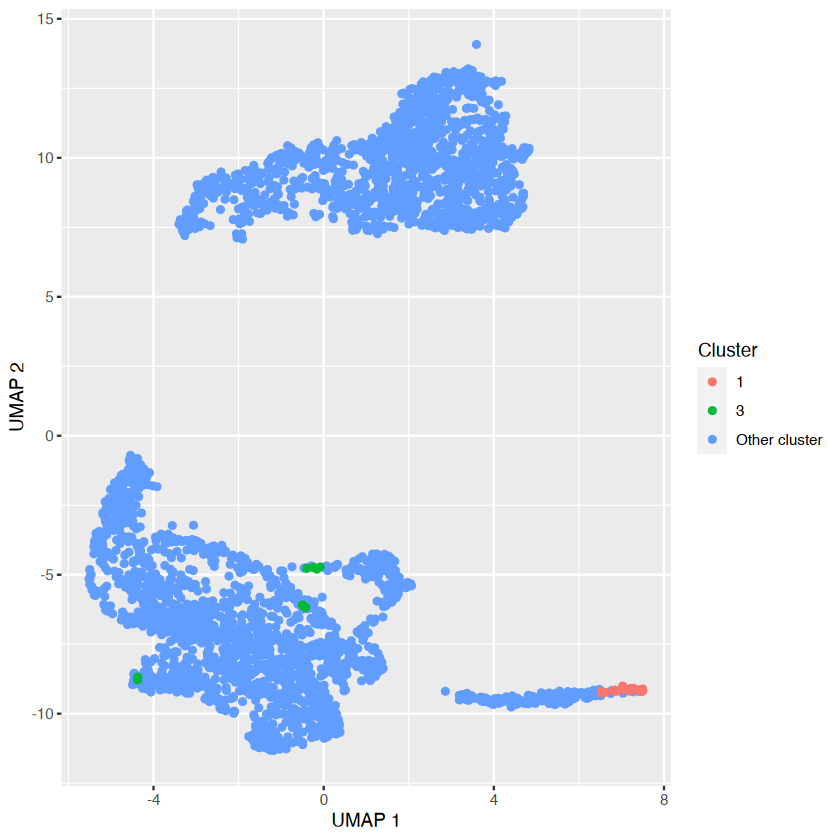

In [6]:
# Those codes are from Gabriele Lubatti
library(parallel)
background <- get_background_full_here(norm_matrix, threshold = 1, n_cells_low = 3, n_cells_high = 20)
result_antonio <- CIARA_final(norm_matrix, knn_matrix, background, cores_number = 1, fdr_value = 0.05, n_cells = 10, approximation = FALSE)


ciara_genes_new=row.names(result_antonio)
geni_top_top_new=row.names(result_antonio)[order(as.numeric(result_antonio[,4]), decreasing = FALSE)]


localized_genes_human <-  detect_localized_genes_final(knn_matrix,norm_matrix,geni_top_top_new,100, 1, approximation = FALSE)  
list_intersect_new <-  localized_genes_human[[2]]
rank_intersect_new <-  localized_genes_human[[1]]
genes_name_text <-  names_localized_genes(list_intersect_new ,geni_top_top_new,max_number = 5)

library(clustree)
library(Biobase)
final_partition = find_number_clusters_final(norm_matrix,rank_intersect_new,list_intersect_new, threshold = 0.50, min_genes_common = 4, max_rank_intersect = 20 )

cluster_new = final_partition[[4]]
index_first = which(cluster_new =="Other cluster")
index_second = which(cluster_new !="Other cluster") 
index_all = c(index_first,index_second)
umap_coordinate[3] <- cluster_new
library("dplyr")  
library(ggthemes)
plot_umap(umap_coordinate[index_all,], cluster_new[index_all]) #+ theme(strip.background = element_blank(), strip.text = element_text(face = 'bold'))

In [ ]:
library(edgeR)

# Prepare a results list for all clusters
cluster_de_results <- list()

# Loop over each cluster
for (cluster in unique(cluster_new)) {
  # Divide cells into current cluster vs others
  cluster_indices <- which(cluster_new == cluster)
  other_indices <- which(cluster_new != cluster)
  
  # Create a binary grouping factor
  group <- factor(c(rep("Cluster", length(cluster_indices)), rep("Other", length(other_indices))))
  
  # Subset the expression matrix
  cluster_norm_matrix <- norm_matrix[, c(cluster_indices, other_indices)]
  
  # Create a DGEList object for edgeR
  dge <- DGEList(counts = cluster_norm_matrix)
  
  # Normalize the data
  dge <- calcNormFactors(dge)
  
  # Create a design matrix
  design <- model.matrix(~ group)
  
  # Estimate dispersions
  dge <- estimateDisp(dge, design)
  
  # Fit the model
  fit <- glmQLFit(dge, design)
  
  # Perform differential expression analysis
  result <- glmQLFTest(fit, coef = 2)
  
  # Extract top genes
  top_genes <- topTags(result, n = Inf)$table
  
  # Store results
  cluster_de_results[[cluster]] <- list(
    cluster = cluster,
    result = top_genes
  )
}

# Display results for each cluster
for (cluster in names(cluster_de_results)) {
  cat("\nTop genes for cluster:", cluster, "\n")
  print(head(cluster_de_results[[cluster]]$result, 10))  # Print top 10 genes
}


## The HVG of cluster 1, 3 seperately. 

In [48]:
# Step 1: Run CIARA globally
background <- get_background_full_here(norm_matrix, threshold = 1, n_cells_low = 3, n_cells_high = 20)
result <- CIARA_final(norm_matrix, knn_matrix, background, cores_number = 1, fdr_value = 0.05, n_cells = 10, approximation = FALSE)

# Step 2: Extract top genes per cluster
rare_clusters <- unique(cluster_new[index_second])  # Use rare cluster IDs
cluster_gene_results <- list()

for (cluster in rare_clusters) {
  # Select cell indices belonging to the current cluster
  cluster_indices <- which(cluster_new == cluster)
  
  # Compute mean expression for genes across cluster-specific cells
  cluster_expression <- rowMeans(norm_matrix[, cluster_indices, drop = FALSE])
  
  # Filter genes based on CIARA results
  ciara_genes <- row.names(result)
  cluster_specific_genes <- intersect(row.names(norm_matrix), ciara_genes)
  
  # Sort cluster-specific genes by expression
  cluster_gene_scores <- cluster_expression[cluster_specific_genes]
  top_genes <- names(sort(cluster_gene_scores, decreasing = TRUE))[1:10]
  
  # Store results
  cluster_gene_results[[cluster]] <- list(
    cluster = cluster,
    genes = top_genes
  )
}

# Step 3: Print the top genes for each cluster
for (cluster in names(cluster_gene_results)) {
  cat("\nTop genes for cluster:", cluster, "\n")
  print(cluster_gene_results[[cluster]]$genes)
}



Top genes for cluster: 1 
 [1] "LOC733765.L" "iqub.L"      "spag1.S"     "elovl2.L"    "pih1d2.L"   
 [6] "cep128.L"    "rgs19.L"     "ccdc40.S"    "cfap52.S"    "saxo2.L"    

Top genes for cluster: 3 
 [1] "gdf3.S"            "vegt.S"            "wnt11b.L"         
 [4] "t.S"               "Xelaev18013504m.g" "t.L"              
 [7] "t2.S"              "flrt3.S"           "rbm20.L"          
[10] "ventx3.2.L"       


## Overall HVG of cluster 1, 3. 

In [45]:
background <- get_background_full_here(norm_matrix, threshold = 1, n_cells_low = 3, n_cells_high = 20) #131
result <- CIARA_final(norm_matrix, knn_matrix, background, cores_number = 1, fdr_value = 0.05, n_cells = 10, approximation = FALSE) #191
ciara_genes <- row.names(result)
top_genes <- ciara_genes[order(as.numeric(result[, 4]), decreasing = FALSE)][1:10]  # Top 10 genes
print(top_genes)


 [1] "gdf3.S"    "t2.S"      "vegt.S"    "ttll13p.L" "wnt11b.L"  "esr-5.L"  
 [7] "t.L"       "t.S"       "elovl2.L"  "rbm20.L"  


In [ ]:
library(ggplot2)
library(gridExtra)

# Initialize a list to store plots
all_plots <- list()

# Loop through each cluster in cluster_gene_results
for (cluster in names(cluster_gene_results)) {
  cat("\nPreparing UMAP plots for cluster:", cluster, "\n")
  
  # Extract the top 10 genes for the cluster
  top_genes <- cluster_gene_results[[cluster]]$genes
  
  # Loop through each gene and create the plot
  for (gene in top_genes) {
    # Check if the gene exists in the norm_matrix
    if (gene %in% rownames(norm_matrix)) {
      # Extract gene expression values from the normalized matrix
      gene_expression <- norm_matrix[gene, ]
      
      # Create a data frame for plotting
      umap_df <- data.frame(
        UMAP1 = umap_coordinate[, 1],
        UMAP2 = umap_coordinate[, 2],
        Expression = gene_expression
      )
      
      # Plot the UMAP with gene expression
      p <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Expression)) +
        geom_point(size = 1.5) +
        scale_color_gradient(low = "gray", high = "blue") +  # Gray to blue gradient
        theme_minimal() +
        labs(title = paste("Cluster", cluster, "-", gene), color = "Expression") +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"))
      
      # Add the plot to the list
      all_plots <- append(all_plots, list(p))
    } else {
      cat("Gene", gene, "not found in norm_matrix\n")
    }
  }
}

# Arrange plots in a grid with 5 plots per row
num_plots <- length(all_plots)
plots_per_row <- 5
grid_rows <- ceiling(num_plots / plots_per_row)

# Display all plots in a grid
grid.arrange(grobs = all_plots, ncol = plots_per_row)


In [8]:
cluster_3 = row.names(umap_coordinate[which(cluster_new =="3"),])

In [12]:
norm_matrix_cluster_3 <- norm_matrix[, cluster_3]
# Compare cluster 3 cells vs. all other clusters
library(edgeR)

# Create a group vector for cells
group <- ifelse(cluster_new == "3", "Cluster3", "Other")

# Prepare the data for edgeR analysis
dge <- DGEList(counts = norm_matrix)
dge <- calcNormFactors(dge)

# Design matrix for the comparison
design <- model.matrix(~ group)

# Estimate dispersion and fit the model
dge <- estimateDisp(dge, design)
fit <- glmQLFit(dge, design)

# Perform differential expression testing
qlf <- glmQLFTest(fit, coef = 2)
top_tags <- topTags(qlf, n = Inf)

# Extract biomarkers for cluster 3
cluster_3_biomarkers <- top_tags$table[which(top_tags$table$FDR < 0.05), ]


Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA



Attaching package: ‘edgeR’


The following object is masked from ‘package:SingleCellExperiment’:

    cpm




In [16]:
# Display the top 10 biomarkers for Cluster 3
top_10_biomarkers <- head(cluster_3_biomarkers, 10)
print(top_10_biomarkers)


                 logFC   logCPM          F       PValue          FDR
gdf3.S       -4.146018 8.962290 2960.65131 3.474327e-44 1.083261e-39
vegt.S       -3.563015 8.975657  694.52917 3.785000e-24 5.900625e-20
t2.S         -3.057213 8.955636 3884.91717 1.084912e-20 1.127549e-16
t.S          -3.334394 8.969202  683.60800 4.276416e-20 3.333359e-16
t.L          -3.090015 8.956871 1904.07099 6.777864e-20 4.226541e-16
rbm20.L      -2.836338 8.956947 1715.90809 1.085527e-15 5.640944e-12
wnt11b.L     -2.989056 9.021773  240.29800 5.402060e-15 2.406155e-11
apoc1-like.L -2.742086 9.086784   83.10759 4.228087e-14 1.647844e-10
cdx4.S       -2.900508 9.008053  163.00254 2.815235e-13 8.610411e-10
cdx1.S       -2.860363 9.023465  125.44082 3.019054e-13 8.610411e-10


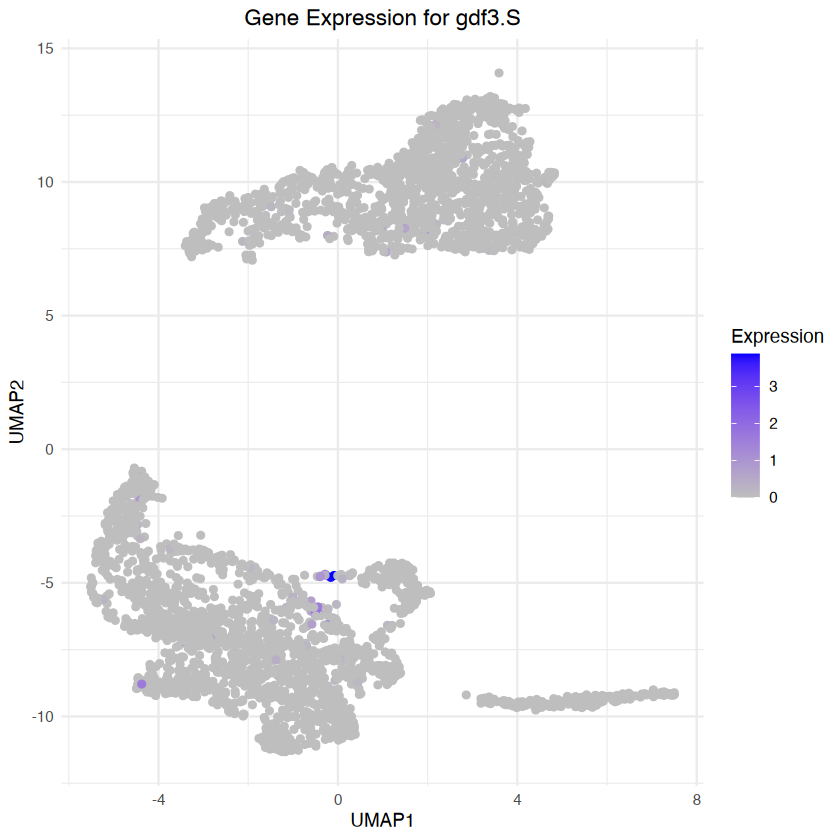

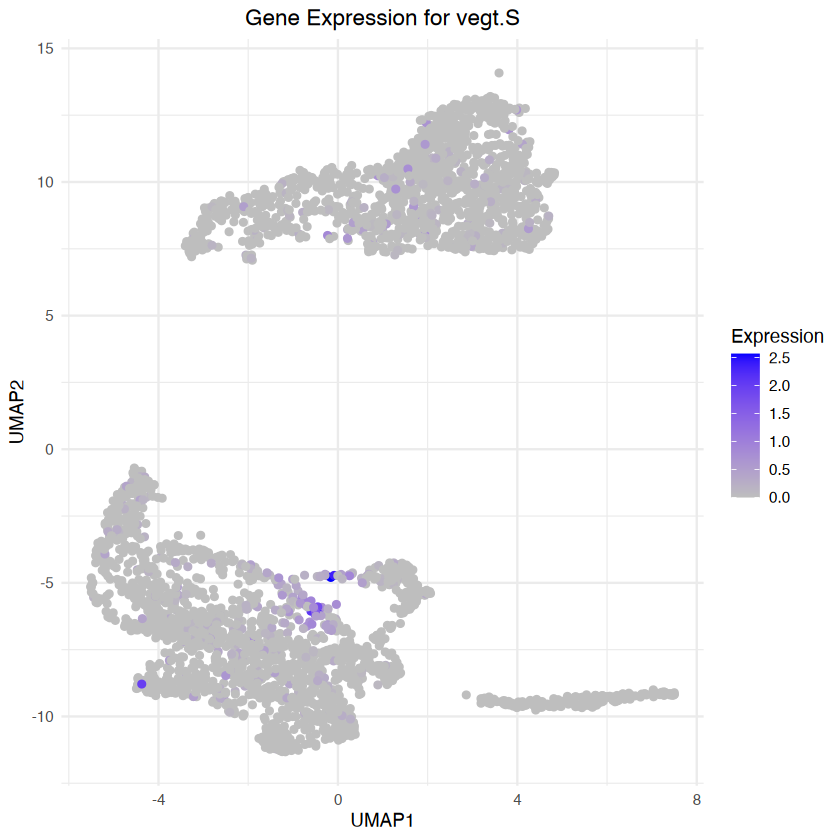

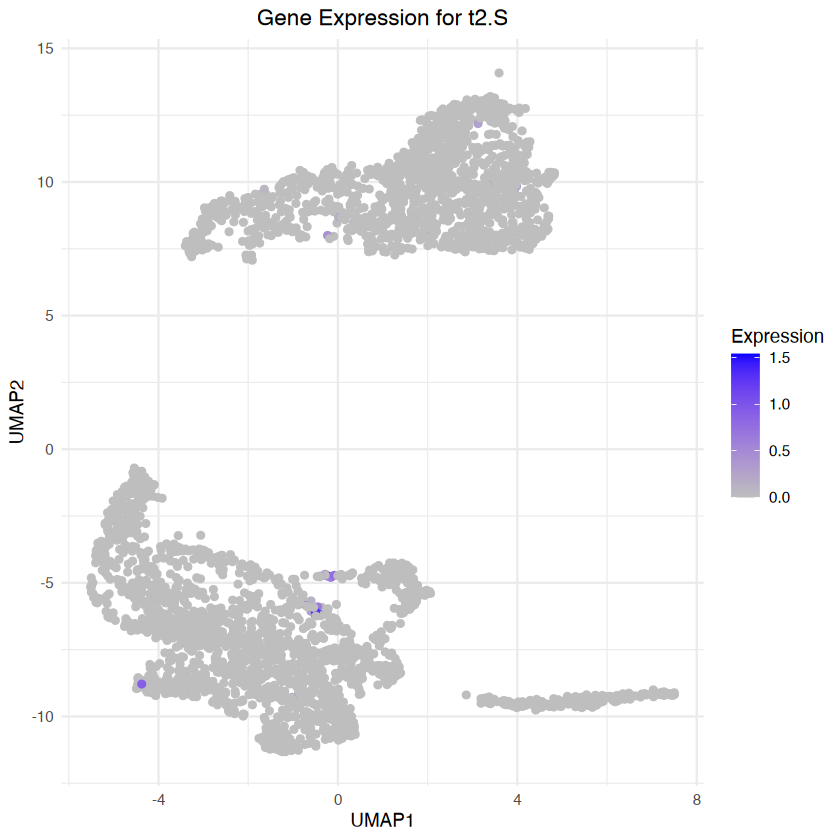

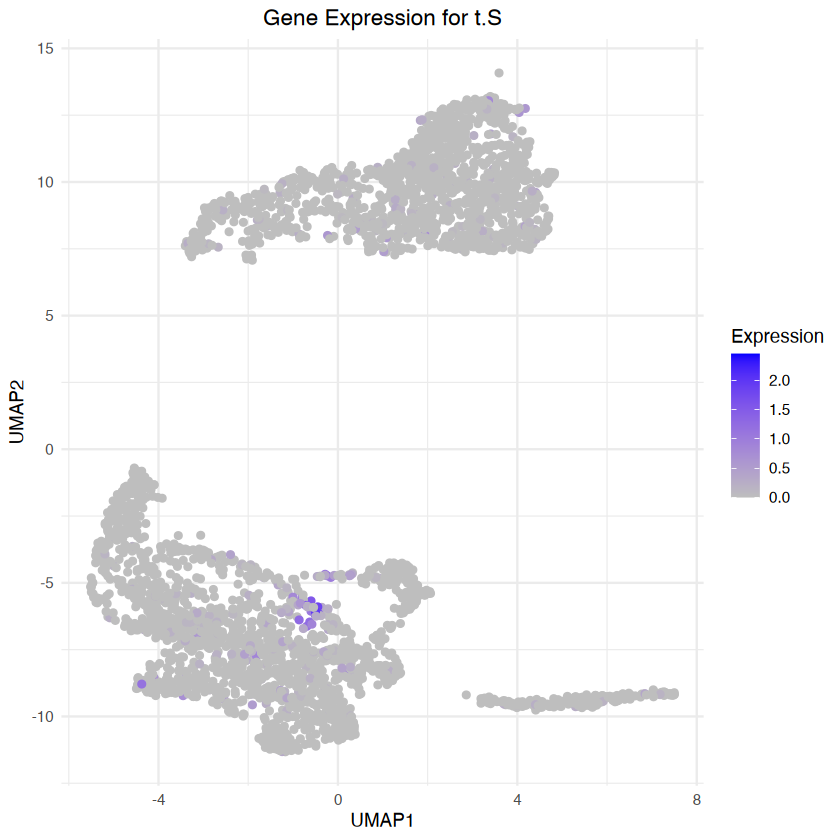

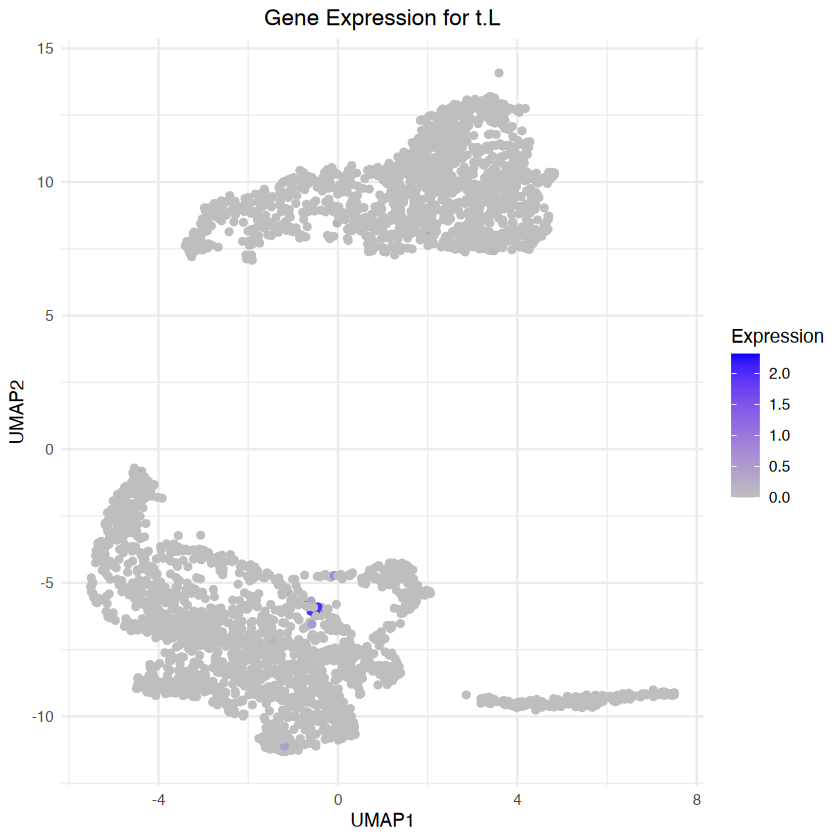

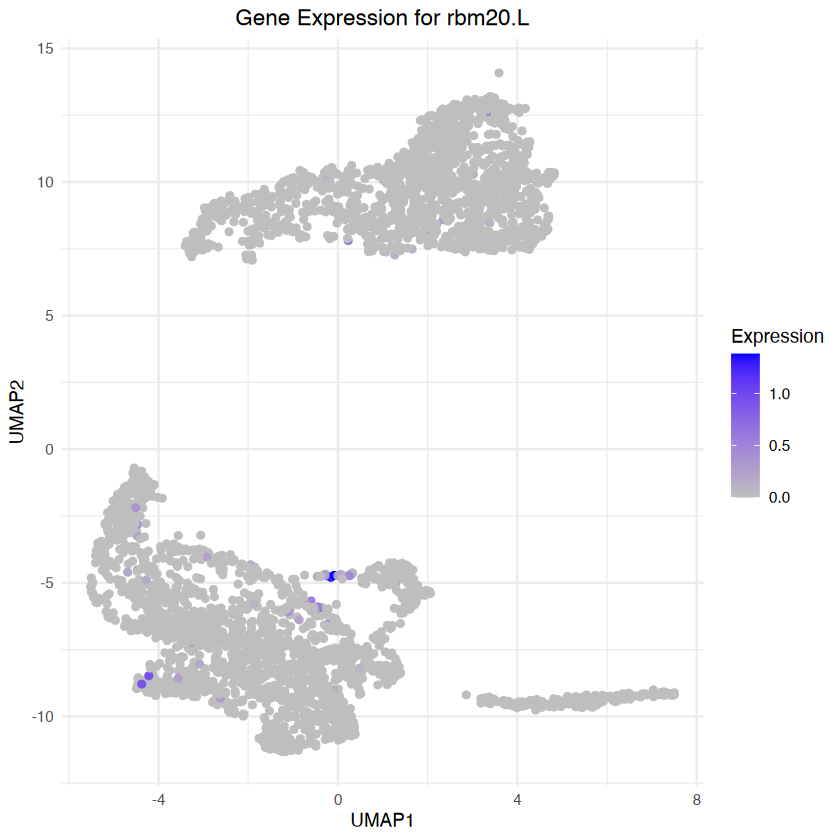

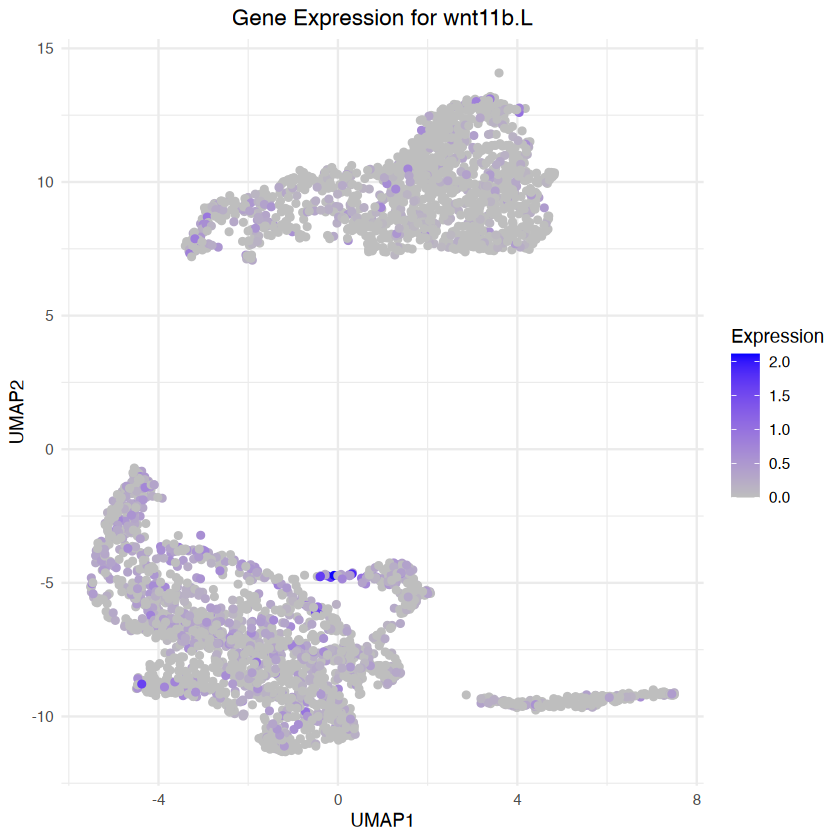

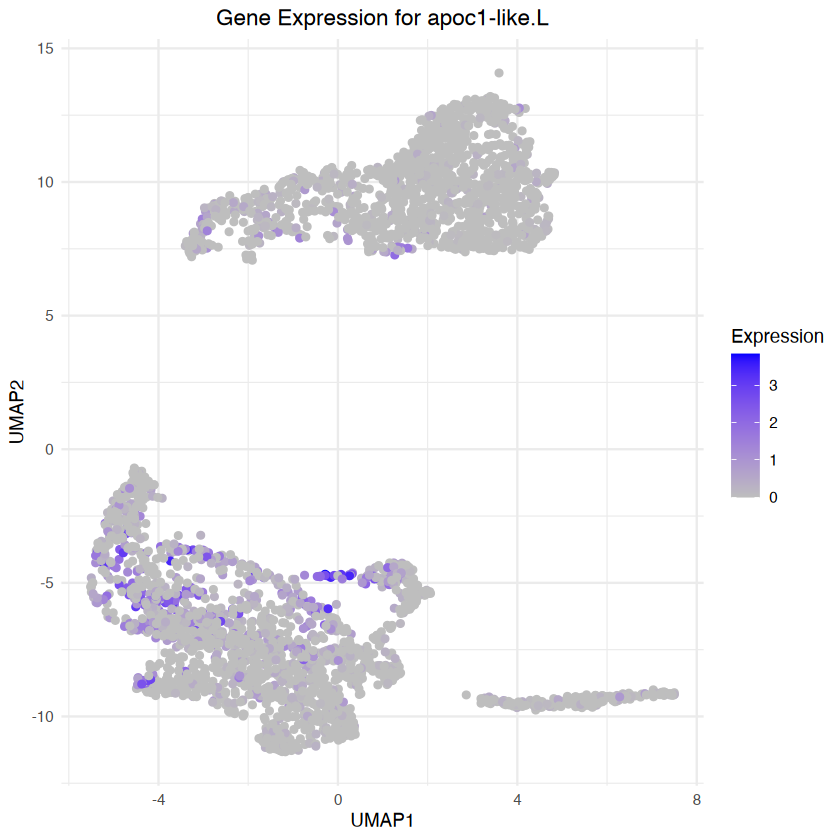

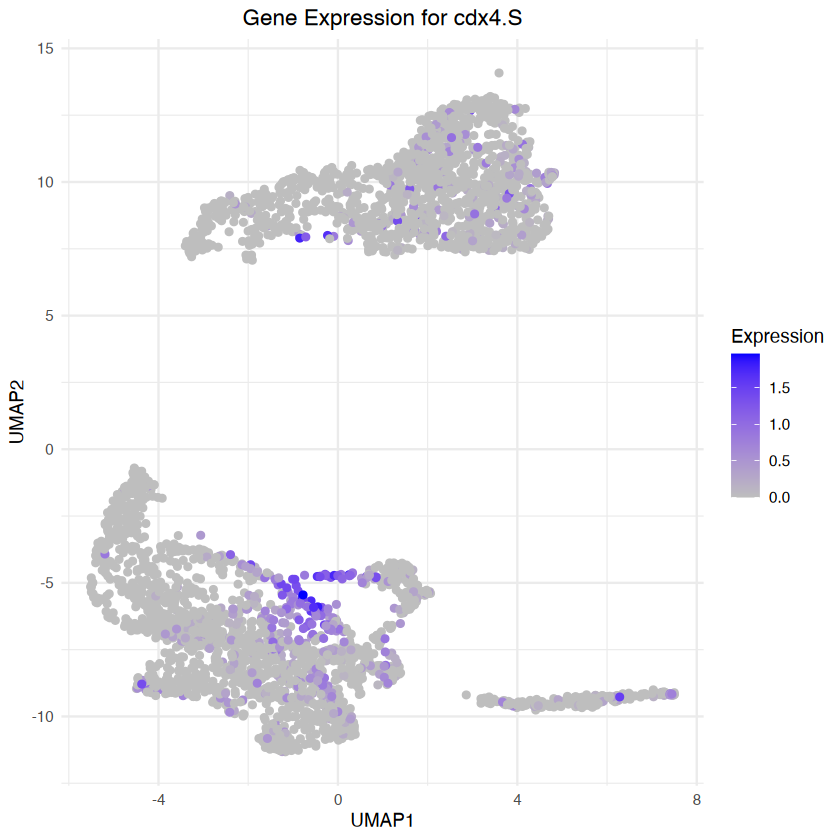

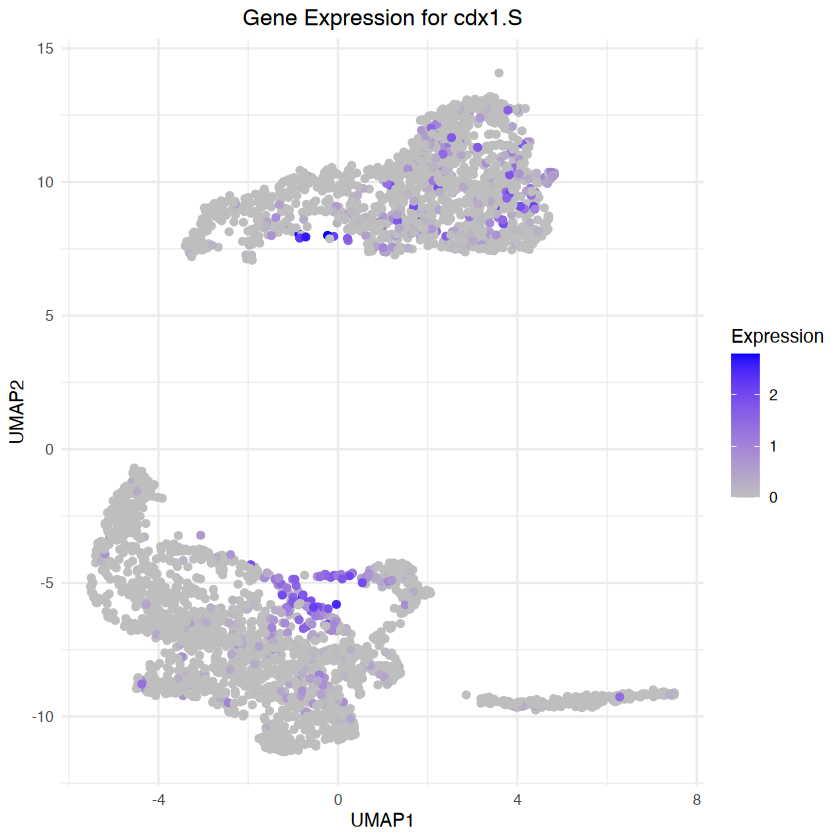

In [20]:
library(ggplot2)

# Extract the top 10 gene names
top_10_gene_names <- rownames(top_10_biomarkers)[1:10]

# Loop through each gene and plot
for (gene in top_10_gene_names) {
  # Extract gene expression values from the normalized matrix
  gene_expression <- norm_matrix[gene, ]
  
  # Create a data frame for plotting
  umap_df <- data.frame(
    UMAP1 = umap_coordinate[, 1],
    UMAP2 = umap_coordinate[, 2],
    Expression = gene_expression
  )
  
  # Plot the UMAP with gene expression
  p <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Expression)) +
    geom_point(size = 1.5) +
    scale_color_gradient(low = "gray", high = "blue") +  # Gray to blue gradient
    theme_minimal() +
    labs(title = paste("Gene Expression for", gene), color = "Expression") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold"))
  
  # Print the plot
  print(p)
}


In [ ]:
load(system.file("extdata", "result.Rda", package = "CIARA"))
ciara_genes <- row.names(result)[result[, 1] < 1]
ciara_genes_top <- row.names(result)[order(as.numeric(result[, 1]))]
coordinate_umap <- as.data.frame(Embeddings(human_data_seurat, reduction = "umap")[, 1:2])
# In the example below we keep the same umap coordinate used in the original paper
meta_info <- readRDS(system.file("extdata", "annot_umap.rds", package ="CIARA"))
coordinate_umap <- meta_info[,2:3]

p=list()
for(i in ciara_genes_top[1:2]){
  q <- plot_gene(norm_matrix, coordinate_umap, i, i)
  p <- list(p,q)
}
p

In [31]:
  for (b in 1: nrow(subset_data@meta.data)){
      for  (a in 1:length(cluster_3)) {
    if (cluster_3[a] == row.names(subset_data@meta.data)[b]){
        subset_data@meta.data$CIARA_cluster[b] <- '3'
        print(row.names(subset_data@meta.data)[b])
        break
      }
     if (cluster_3[a] != row.names(subset_data@meta.data)[b]){
        subset_data@meta.data$CIARA_cluster[b] <- 'other cluster'
      }
    }
  }


[1] "AGAAGTAAGTACGTCT.1"
[1] "ATGATCGCAAATGATG.1"
[1] "CCACGTTCACCCGTAG.1"
[1] "TCGTAGATCGCCACTT.1"


In [32]:
saveRDS(subset_data, file = "Data by Ding Yang/cluster_9_data.rds")

# Making Diffusion component map with integrated Data

In [ ]:
subset_data <- subset(vedo, idents = 9)

In [ ]:
subset_data <- SCTransform(subset_data, ncells = 134,  variable.features.n = 3000) # replace normalize, FindVariableFeatures, and scale

Warning message in DiffusionMap(t(as.matrix(deng)), verbose = TRUE):
“You have 2000 genes. Consider passing e.g. n_pcs = 50 to speed up computation.”


finding knns......done. Time: 0.09s
Calculating transition probabilities...

Warning message:
“'as(<dsCMatrix>, "dsTMatrix")' is deprecated.
Use 'as(., "TsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").”


...done. Time: 0.01s

performing eigen decomposition......done. Time: 0.00s


[1]  14  68 102

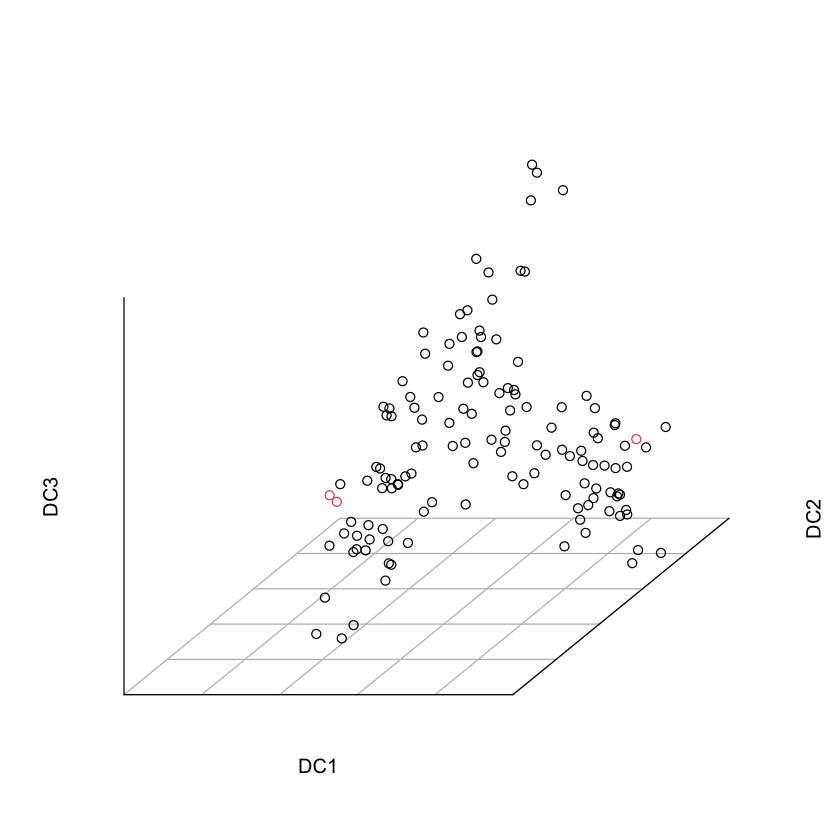

In [33]:
deng <- subset_data@assays$integrated@data  # access log-transformed counts matrix
# Make a diffusion map.
dm <- DiffusionMap(t(as.matrix(deng)), verbose = TRUE)
find_tips(dm)
is_tip <- l_which(find_tips(dm), len = nrow(dataset(dm)))

plot(dm, col = factor(is_tip)) #plot the tips at 14, 68, 102

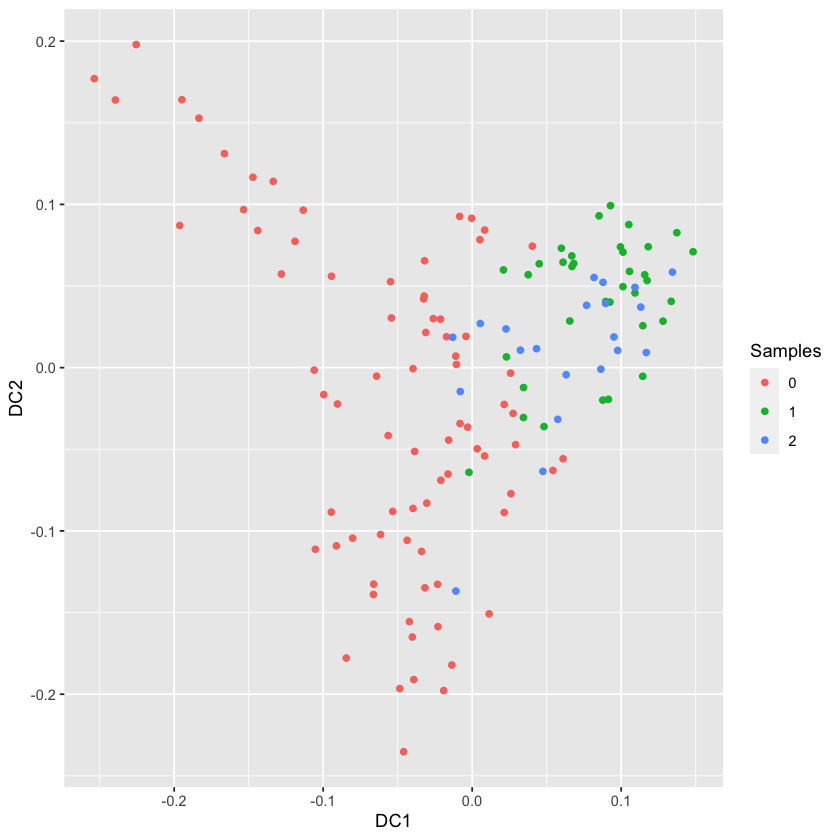

In [34]:
dpt <- DPT(dm, tips = 68) #tips could be 14, 68, 102
df <- data.frame(DC1 = eigenvectors(dm)[, 1],
                  DC2 = eigenvectors(dm)[, 2],
                  DC3 = eigenvectors(dm)[, 3],
                  DC4 = eigenvectors(dm)[, 4],
                  dptval = dpt$dpt,
                  Samples = subset_data@active.ident,
                 experment = subset_data@meta.data$exp,
                  Nt= subset_data@meta.data$isnt,
                CIARA = subset_data@meta.data$CIARA_cluster)

ggplot(df) + geom_point(aes(x = DC1, y = DC2, color = Samples))


# make PCA plot

In [35]:
subset_data

An object of class Seurat 
48668 features across 134 samples within 3 assays 
Active assay: SCT (15489 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, integrated
 3 dimensional reductions calculated: pca, umap, tsne

In [37]:
library(scater)
deng_SCE<- as.SingleCellExperiment(subset_data)
deng_SCE <- runPCA(deng_SCE, ncomponents = 6)
# Use the reducedDim function to access the PCA and store the results. 
pca <- reducedDim(deng_SCE, "PCA")
deng_SCE$PC1 <- pca[, 1]
deng_SCE$PC2 <- pca[, 2]
# Describe how the PCA is stored in a matrix. Why does it have this structure?

Loading required package: scuttle



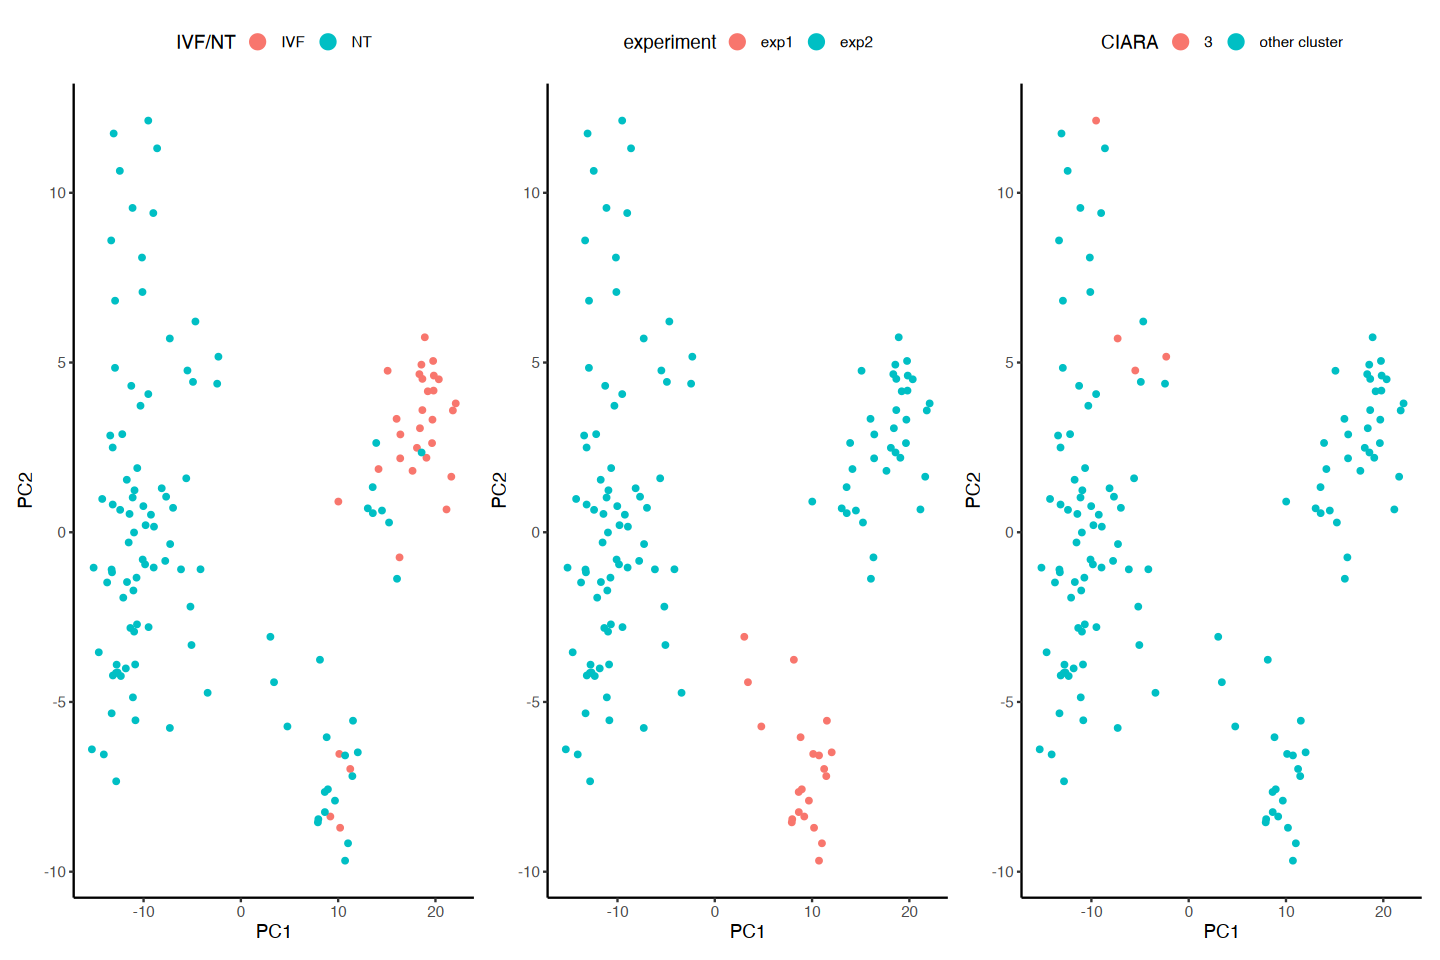

In [38]:
library(patchwork)
options(repr.plot.width=12, repr.plot.height=8)


p1<-ggplot(as.data.frame(colData(deng_SCE)), aes(x = -PC1, y = -PC2,  color = subset_data@meta.data$isnt)) +
  geom_point( size =1.15) +
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=3.8)))  + labs(col = "IVF/NT") + xlab("PC1") + ylab("PC2")+ theme(legend.position = "top")

p2<-ggplot(as.data.frame(colData(deng_SCE)), aes(x = -PC1, y = -PC2,  color = subset_data@meta.data$exp)) +
  geom_point( size =1.15) +
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=3.8)))  + labs(col = "experiment") + xlab("PC1") + ylab("PC2")+ theme(legend.position = "top")
p3<-ggplot(as.data.frame(colData(deng_SCE)), aes(x = -PC1, y = -PC2,  color = subset_data@meta.data$CIARA_cluster)) +
  geom_point( size =1.15) +
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=3.8)))  + labs(col = "CIARA") + xlab("PC1") + ylab("PC2")+ theme(legend.position = "top")

plot3 <- p1 + p2 + p3
plot3

# original

# Finding differentially expressed features (cluster biomarkers)

In [39]:
cluster0.markers <- FindMarkers(subset_data, ident.1 = 0, min.pct = 0.25)
head(cluster0.markers, n = 10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
foxi1.S,1.323454e-23,-5.276088,0.167,0.982,2.049898e-19
fgfr4.S,1.622233e-23,-2.683162,0.269,1.000,2.512676e-19
gfpt1.L,2.046887e-23,-3.161828,0.500,1.000,3.170423e-19
btg1.S,7.784172e-23,-2.682618,0.308,1.000,1.205690e-18
eif4a1.S,1.077969e-22,-3.837703,0.910,1.000,1.669666e-18
atp2a2.S,1.140587e-22,-2.181711,1.000,1.000,1.766655e-18
ilf3.S,1.235510e-22,-1.942945,1.000,1.000,1.913681e-18
gata2.S,1.289582e-22,-3.732543,0.526,1.000,1.997434e-18
srsf5.L,1.359615e-22,-2.029669,0.987,1.000,2.105908e-18


In [40]:
cluster1.markers <- FindMarkers(subset_data, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gata3.L,3.851544e-21,2.232140,0.914,0.091,5.965656e-17
foxi1.S,1.154089e-20,4.893379,1.000,0.333,1.787569e-16
gata3.S,2.644039e-20,2.770721,0.914,0.121,4.095353e-16
kitlg.S,5.005357e-20,2.969559,0.857,0.081,7.752798e-16
actn1.L,5.786579e-20,1.878585,0.943,0.152,8.962832e-16
LOC101731452.L,7.372362e-20,1.307429,0.914,0.081,1.141905e-15
Xelaev18029977m.g,8.721119e-20,2.165410,0.971,0.212,1.350814e-15
hmx3.L,2.059623e-19,3.349514,0.800,0.051,3.190150e-15
slc30a8.L,3.673202e-19,2.058702,0.943,0.141,5.689422e-15


In [41]:
cluster2.markers <- FindMarkers(subset_data, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ncor2.L,7.307280e-16,1.937811,0.810,0.097,1.131825e-11
stat1.S,1.707999e-15,1.605649,0.762,0.071,2.645519e-11
hnrnpa2b1.S,3.886294e-13,-1.360197,1.000,1.000,6.019481e-09
prmt1.L,3.899842e-13,-1.593947,1.000,1.000,6.040465e-09
sumo2.S,4.392261e-13,-1.491119,1.000,1.000,6.803173e-09
srsf3.S,4.536431e-13,-1.482810,1.000,1.000,7.026478e-09
gng5.L,5.058119e-13,-1.421367,1.000,1.000,7.834520e-09
snrpe.S,5.113643e-13,-1.607961,1.000,1.000,7.920521e-09
snrpd1.S,6.473023e-13,-1.508462,1.000,1.000,1.002607e-08


In [42]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(subset_data, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.966617e-22,3.690813,1.000,0.661,4.594993e-18,0,march8.L
3.439782e-22,2.858060,1.000,0.679,5.327878e-18,0,Xelaev18000010m.g
3.757190e-22,3.959934,1.000,0.607,5.819512e-18,0,Xelaev18000342m.g
1.419332e-21,2.597902,1.000,0.732,2.198403e-17,0,pdk4.S
4.206506e-21,2.846303,0.987,0.607,6.515457e-17,0,LOC100490020.L
1.532017e-20,3.243578,0.987,0.571,2.372941e-16,0,loc100494294.L
2.138407e-20,3.035246,0.987,0.643,3.312179e-16,0,sfrp2.S
1.045387e-13,3.369274,0.872,0.482,1.619200e-09,0,sfrp2.L
1.041341e-05,2.968604,0.744,0.536,1.612934e-01,0,apoc1-like.L


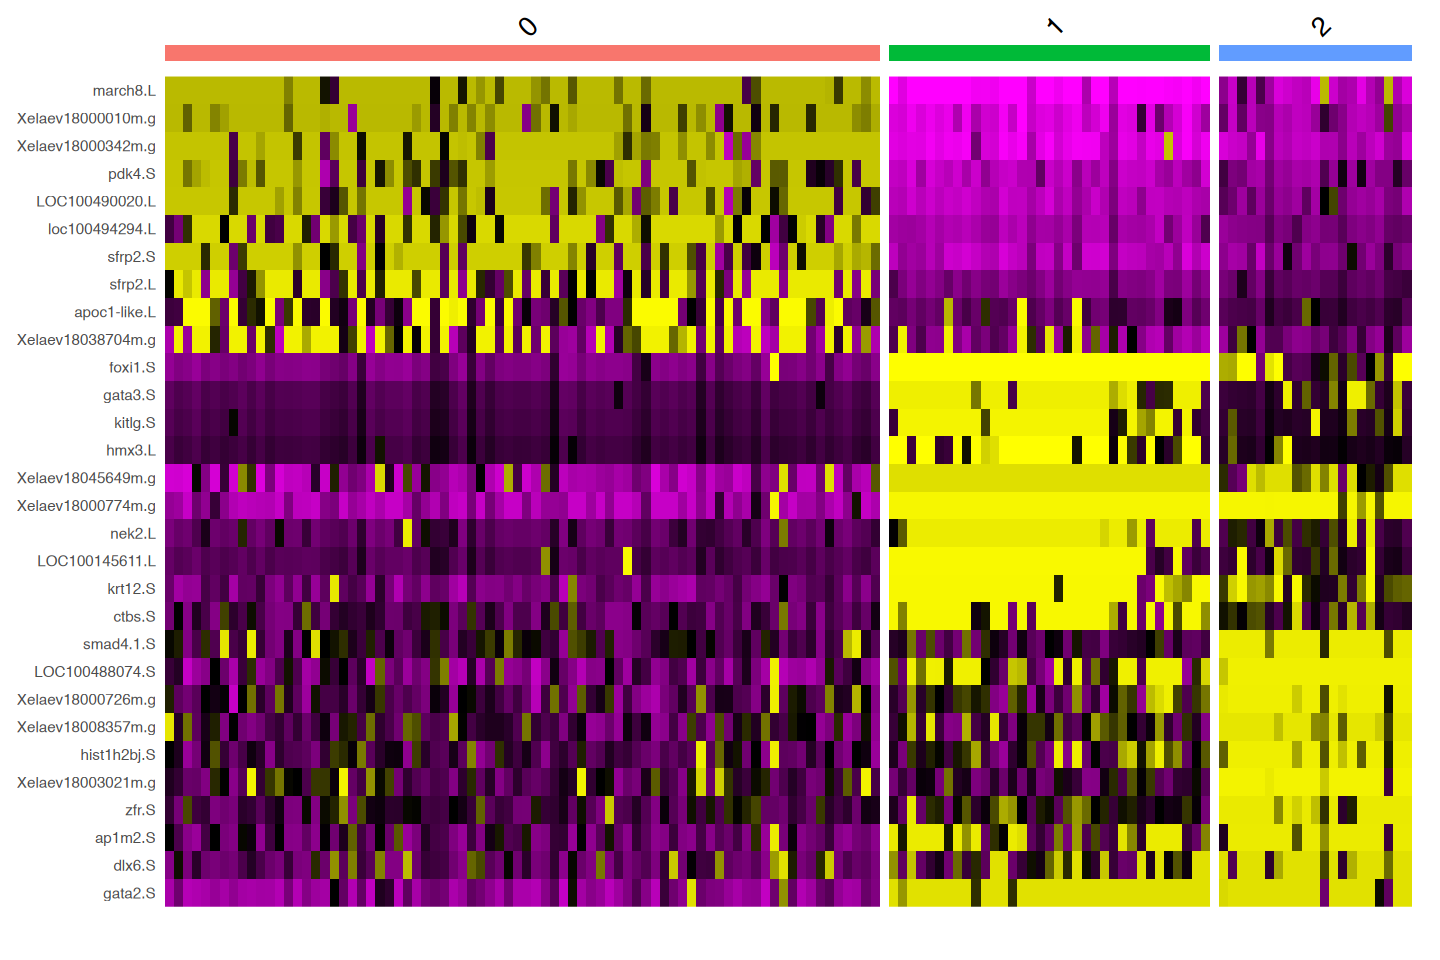

In [43]:
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
DoHeatmap(subset_data, features = top10$gene) + NoLegend()



In [44]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-apple-darwin20 (64-bit)
Running under: macOS Monterey 12.3

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: Europe/Berlin
tzcode source: internal

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] patchwork_1.1.3             scater_1.28.0              
 [3] scuttle_1.10.3              clustree_0.5.1             
 [5] ggraph_2.1.0                SingleCellExperiment_1.22.0
 [7] SummarizedExperiment_1.30.2 Biobase_2.60.0             
 [9] GenomicRanges_1.52.1        GenomeInfoDb_1.36.4        
[11] IRanges_2.34.1              S4Vectors_0.38.2           
[13] BiocGenerics_0.46